In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pickle
import pandas as pd
import os
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
!pip install positional-encodings

In [3]:
def load_pickle(path):
    with open(path,'rb') as f:
        return pickle.load(f)

def write_pickle(path, d):
    with open(path,'wb+') as f:
        return pickle.dump(d, f, protocol = pickle.HIGHEST_PROTOCOL)

In [4]:
conv1 = load_pickle('./drive/MyDrive/hidden-networks/dataset/conv1_s02.pkl')
conv2 = load_pickle('./drive/MyDrive/hidden-networks/dataset/conv2_s02.pkl')
fc1 = load_pickle('./drive/MyDrive/hidden-networks/dataset/fc1_s02.pkl')
fc2 = load_pickle('./drive/MyDrive/hidden-networks/dataset/fc2_s02.pkl')

In [5]:
conv1_masks, conv1_weights = conv1
conv1_masks = conv1_masks.squeeze()
conv1_weights = conv1_weights.squeeze()
conv2_masks, conv2_weights = conv2
conv2_masks = conv2_masks.squeeze()
conv2_weights = conv2_weights.squeeze()
fc1_masks, fc1_weights = fc1
fc2_masks, fc2_weights = fc2

In [6]:
def get_sign(weight):
  if weight > 0:
    return 1
  elif weight < 0:
    return -1
  else:
    return 0

In [7]:
def process_weight(weight):
  return abs(weight).item(), get_sign(weight)

In [8]:
pos_pruned = 0
neg_pruned = 0
zero_pruned = 0
for i in range(len(conv1_weights)):
  for k in range(len(conv1_weights[0])):
    for j in range(len(conv1_weights[0][0])):
      sign = get_sign(conv1_weights[i][j][k])
      if conv1_masks[i][j][k] == 0:
        if sign == 1:
          pos_pruned += 1
        elif sign == 0:
          zero_pruned += 1
        else:
          neg_pruned += 1

print(pos_pruned, neg_pruned, zero_pruned)

151 131 0


In [9]:
conv2_weights.shape

torch.Size([64, 32, 3, 3])

In [41]:
from positional_encodings import PositionalEncoding1D, PositionalEncoding2D, PositionalEncoding3D

p_enc_2d = PositionalEncoding2D(4)
y = torch.zeros((1,12,12,4))
mapper = p_enc_2d(y).squeeze()

In [40]:
#0 means pruned 1 means not pruned
fc_df = pd.read_csv('./drive/MyDrive/hidden-networks/dataset/fc1_pruned_data.csv')

In [50]:
fc_df['pos1'] = fc_df.apply(lambda row: mapper[int((row.i % 144) / 12)][(row.i % 144) % 12][0].item(), axis=1)
fc_df['pos2'] = fc_df.apply(lambda row: mapper[int((row.i % 144) / 12)][(row.i % 144) % 12][1].item(), axis=1)
fc_df['pos3'] = fc_df.apply(lambda row: mapper[int((row.i % 144) / 12)][(row.i % 144) % 12][2].item(), axis=1)
fc_df['pos4'] = fc_df.apply(lambda row: mapper[int((row.i % 144) / 12)][(row.i % 144) % 12][3].item(), axis=1)

In [12]:
pos_pruned = 0
neg_pruned = 0
zero_pruned = 0
for i in range(len(fc2_weights)):
    for j in range(len(fc2_weights[0])):
      sign = get_sign(fc2_weights[i][j])
      if fc2_masks[i][j] == 0:
        if sign == 1:
          pos_pruned += 1
        elif sign == 0:
          zero_pruned += 1
        else:
          neg_pruned += 1

print(pos_pruned, neg_pruned, zero_pruned)

621 633 0


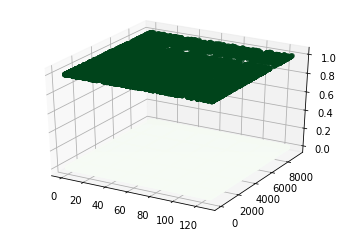

In [14]:
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure()
ax = plt.axes(projection='3d')

ax = plt.axes(projection='3d')

# Data for a three-dimensional line
# zline = np.linspace(0, 15, 1000)
# xline = np.sin(zline)
# yline = np.cos(zline)
# ax.plot3D(xline, yline, zline, 'gray')

x_data = []
y_data = []
z_data = []
for i in range(len(fc1_weights)):
  for j in range(len(fc1_weights[0])):
    x_data += [i]
    y_data += [j]
    z_data += [int(fc1_masks[i][j].item())]

ax.scatter3D(x_data, y_data, z_data, c=z_data, cmap='Greens');

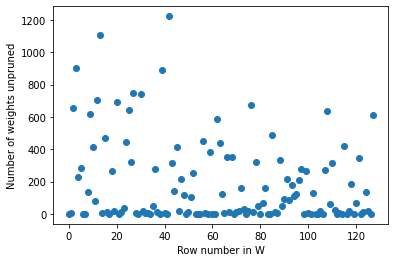

In [17]:
import matplotlib.pyplot as plt
from collections import Counter

x_data = []
z_data = []

#row
# for i in range(len(fc1_weights[0])):
#   x_data += [i]
#   z_data += [Counter(fc1_masks[:, i].cpu().numpy().astype(int))[1]]

#column
for i in range(len(fc1_weights)):
  x_data += [i]
  z_data += [Counter(fc1_masks[i].cpu().numpy().astype(int))[1]]
 
# plotting the points
plt.scatter(x_data, z_data)
 
# naming the x axis
plt.xlabel('Row number in W')
# naming the y axis
plt.ylabel('Number of weights unpruned')
  
# function to show the plot
plt.show()

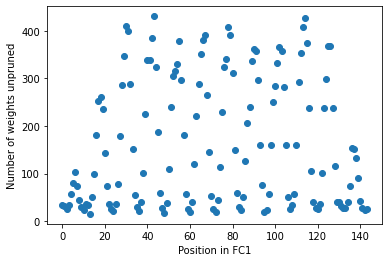

In [18]:
z_data = {}
for i in range(len(fc1_weights.T)):
  if i % 144 not in z_data:
    z_data[i % 144] = Counter(fc1_masks.T[i].cpu().numpy().astype(int))[1]
  else: 
    z_data[i % 144] += Counter(fc1_masks.T[i].cpu().numpy().astype(int))[1]

plt.scatter(list(z_data.keys()), list(z_data.values()))
 
# naming the x axis
plt.xticks(range(0, 144), 12)
plt.xlabel('Position in FC1')
# naming the y axis
plt.ylabel('Number of weights unpruned')
  
# function to show the plot
plt.show()

In [94]:
def conv2_norm(fc1_weights, conv2_weights, conv2_output_dim):
  data = torch.zeros([len(fc1_weights), len(fc1_weights[0])], dtype=torch.float32)
  flat_length = conv2_output_dim ** 2
  for i in range(len(conv2_weights)):
    #can replace pruned_count with some other function
    norm = torch.linalg.norm(conv2_weights[i])
    data[i*flat_length:(i+1)*flat_length] = norm

  return data

#dimension of input by output
def fc2_norm(fc1_weights, fc2_weights):
  data = torch.zeros([len(fc1_weights), len(fc1_weights[0])], dtype=torch.float32)
  for j in range(len(fc1_weights[0])):
    norm = torch.norm(fc2_weights[j])
    data[:, j] = norm

  return data

def make_pruned_df(conv2_mat, fc2_mat):
  i_list = [] 
  j_list = [] 
  c2_list = []
  fc2_list = []

  for i in range(len(conv2_mat)):
    for j in range(len(conv2_mat[0])):
      i_list += [i]
      j_list += [j]
      c2_list += [conv2_mat[i][j].item()]
      fc2_list += [fc2_mat[i][j].item()]
  
  d = {'i': i_list, 'j': j_list, 'conv2_norm': c2_list, 'fc2_norm': fc2_list}
  return pd.DataFrame(data=d)

d1 = conv2_norm(fc1_weights.T, conv2_weights, 12)
d2 = fc2_norm(fc1_weights.T, fc2_weights.T)
norm_fc_data = make_pruned_df(d1, d2)

In [97]:
fc_df = pd.merge(fc_df, norm_fc_data, how='inner', left_on=['i','j'], right_on = ['i','j'])

In [98]:
fc_df.head()

,Unnamed: 0,i,j,mag_0,mag_1,mag_2,mag_3,mag_4,sign_0,sign_1,...,layer,include,conv2_pruned_count,fc2_pruned_count,pos1,pos2,pos3,pos4,conv2_norm,fc2_norm
0,0,0,0,0.030562,0.0,0.014480,0.000000,0.004028,-1,0,...,fc1,0.0,287,10,0.0,1.0,0.0,1.0,1.372666,0.285296
1,1,0,1,0.004028,0.0,0.008821,0.030562,0.000699,-1,0,...,fc1,0.0,287,10,0.0,1.0,0.0,1.0,1.372666,0.484385
2,2,0,2,0.000699,0.0,0.000850,0.004028,0.010435,1,0,...,fc1,0.0,287,10,0.0,1.0,0.0,1.0,1.372666,0.347910
3,3,0,3,0.010435,0.0,0.006745,0.000699,0.004159,-1,0,...,fc1,0.0,287,10,0.0,1.0,0.0,1.0,1.372666,0.395011
4,4,0,4,0.004159,0.0,0.043119,0.010435,0.024601,-1,0,...,fc1,0.0,287,10,0.0,1.0,0.0,1.0,1.372666,0.367281


Logistic Regression

In [60]:
import statsmodels.formula.api as smf

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [61]:
fc_df.columns

Index(['Unnamed: 0', 'i', 'j', 'mag_0', 'mag_1', 'mag_2', 'mag_3', 'mag_4',
       'sign_0', 'sign_1', 'sign_2', 'sign_3', 'sign_4', 'sparsity', 'layer',
       'include', 'conv2_pruned_count', 'fc2_pruned_count', 'pos1', 'pos2',
       'pos3', 'pos4'],
      dtype='object')

In [99]:
log_reg = smf.logit("include ~ mag_0 + mag_2 + mag_3 + mag_4 + sign_0 + conv2_pruned_count + fc2_pruned_count + pos1 + pos2 + pos3 + pos4 + conv2_norm + fc2_norm", data=fc_df).fit()

Optimization terminated successfully.
         Current function value: 0.085036
         Iterations 9


In [100]:
log_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                include   No. Observations:              1179648
Model:                          Logit   Df Residuals:                  1179634
Method:                           MLE   Df Model:                           13
Date:                Sun, 10 Apr 2022   Pseudo R-squ.:                  0.1326
Time:                        04:07:06   Log-Likelihood:            -1.0031e+05
converged:                       True   LL-Null:                   -1.1565e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -1.0421      0.359     -2.901      0.004      -1.746      -0.338
mag_0                 91.9428      0.593    155.015      0.000      90.780      93.105
mag_2                  1.2998      0.757      1.717      0.086      -0.184       2.784
mag_3                  1.5878      0.756      2.101      0.036       0.107       3.069
mag_4                 -3.0011      0.766     -3.918      0.000      -4.503      -1.500
sign_0                -0.3105      0.007    -44.286      0.000      -0.324      -0.297
conv2_pruned_count    -0.0116      0.001    -12.236      0.000      -0.013      -0.010
fc2_pruned_count      -0.5449      0.011    -50.537      0.000      -0.566      -0.524
pos1                   0.1192      0.010     12.360      0.000       0.100       0.138
pos2                  -0.2215      0.010    -22.808      0.000      -0.241      -0.202
pos3                  -0.0930      0.010     -9.711      0.000      -0.112      -0.074
pos4                   0.1936      0.010     20.219      0.000       0.175       0.212
conv2_norm             1.8791      0.113     16.613      0.000       1.657       2.101
fc2_norm               3.7929      0.085     44.593      0.000       3.626       3.960
======================================================================================
"""